In [1]:
import glob
import json
from tqdm import tqdm
import os
import json
import pandas as pd
import re
import polars as pl

# Exploring FineWeb Edu

In [2]:
import polars as pl
#!wget https://huggingface.co/datasets/HuggingFaceFW/fineweb-edu/resolve/main/sample/10BT/000_00000.parquet
x= pl.scan_parquet('./000_00000.parquet')
x.head().collect()

text,id,dump,url,date,file_path,language,language_score,token_count,score,int_score
str,str,str,str,str,str,str,f64,i64,f64,i64
"""This project is solving the As…","""<urn:uuid:6c17be7f-7253-4703-a…","""CC-MAIN-2024-51""","""http://2014.spaceappschallenge…","""2024-12-01T17:43:40Z""","""s3://commoncrawl/crawl-data/CC…","""en""",0.914297,825,2.96875,3
"""Life of a Sand Grain THE LIFE …","""<urn:uuid:17e4ca7f-a10a-461b-8…","""CC-MAIN-2024-51""","""http://blog.azgs.arizona.edu/i…","""2024-12-01T18:24:12Z""","""s3://commoncrawl/crawl-data/CC…","""en""",0.959785,2344,3.546875,4
"""The internet of things, a syst…","""<urn:uuid:6e9f6c85-2d16-4f82-b…","""CC-MAIN-2024-51""","""http://codetechsolutions.co.uk…","""2024-12-01T17:12:59Z""","""s3://commoncrawl/crawl-data/CC…","""en""",0.931961,270,3.484375,3
"""An archive photo of an Egyptia…","""<urn:uuid:47064b08-fcce-4923-9…","""CC-MAIN-2024-51""","""http://en.aswatmasriya.com/new…","""2024-12-01T17:42:22Z""","""s3://commoncrawl/crawl-data/CC…","""en""",0.961632,367,2.75,3
"""The faith of the Christ-God is…","""<urn:uuid:e9c8abb4-8d22-4031-a…","""CC-MAIN-2024-51""","""http://faithandheritage.com/20…","""2024-12-01T18:21:21Z""","""s3://commoncrawl/crawl-data/CC…","""en""",0.958506,2450,2.6875,3


In [3]:
x= pl.scan_parquet(glob.glob('./*_00000.parquet'))
x = x.filter((pl.col('token_count')>100)&(pl.col('score')>3.)&(pl.col('language')=='en')&(pl.col('language_score')>0.95))
x = x.collect()

In [4]:
print(f'Number of texts: {x.shape[0]}, number of tokens {x["token_count"].sum()/1e6} M')

Number of texts: 450026, number of tokens 490.784759 M


# Let's build our own data annotator!

In [5]:
import pandas as pd
import google.generativeai as genai
import os
import time
import json
from dotenv import load_dotenv
from tqdm import tqdm  # Import tqdm for progress bar

load_dotenv()
API_KEY = os.getenv("MY_API_KEY")

if not API_KEY:
    raise ValueError("Google API Key not found. Please set the GOOGLE_API_KEY environment variable or define it in the script.")

genai.configure(api_key=API_KEY)


MODEL_NAME = "gemini-1.5-flash-8b"

ALLOWED_TOPICS = [
    "Arts & Humanities",
    "History & Archaeology",
    "Social Sciences",
    "Mathematics",
    "Physical Sciences",
    "Children entertrainment",    
    "Computer Science",
    "Engineering & Technology",
    "Life Sciences",
    "Health & Medicine",
    "Education Studies",
    "Business & Finance",
    "Law & Legal Studies",
    "Environmental Science & Sustainability",
    "Languages & Linguistics",
    "Daily Routines & Home Management",
    "Family & Interpersonal Relationships",
    "Hobbies, Leisure & Entertainment",
    "Personal Health, Wellness & Lifestyle", 
    "Work Life & Career", 
    "Consumer Experiences & Personal Finance",
    "Personal Journeys & Life Events",
    "Food & Culinary"    
]

EDUCATION_LEVEL = ["primary school", "middle school", "high school", "university degree", "PhD degree"]

def classify_text_with_gemini(text_to_classify):
    """
    Uses Gemini to classify text into topic and complexity.

    Args:
        text_to_classify (str): The text content to classify.

    Returns:
        tuple: (topic, complexity) or (None, None) if an error occurs.
    """
    # Ensure text is not empty or just whitespace
    if not text_to_classify or text_to_classify.isspace():
        #print("Warning: Skipping empty or whitespace-only text.")
        return None, None

    max_length = 15000
    if len(text_to_classify) > max_length:
        text_to_classify = text_to_classify[:max_length] + "..." # Truncate

    prompt = f"""
Analyze the following text and determine its primary topic and the educational level typically required to understand it.

Text:
"{text_to_classify}"

Instructions:
1. Choose the *single best* topic from this list: {ALLOWED_TOPICS}
2. Choose the *single most appropriate* education level one would need to properly understand the text: {EDUCATION_LEVEL}
3. Provide your answer ONLY in the following JSON format:
   {{"topic": "SELECTED_TOPIC", "education": "SELECTED_EDUCATION"}}

Example Response:
{{"topic": "Science", "education": "high school"}}

Output ONLY the JSON object.
"""

    try:
        model = genai.GenerativeModel('gemini-1.5-flash-8b')
        response = model.generate_content(
            prompt,
            generation_config=genai.types.GenerationConfig(
                max_output_tokens=50, # Limit output size
                temperature=0.1 # Lower temperature for more deterministic classification
            )
            )
        raw_response_text = response.text.strip()
        
        if raw_response_text.startswith("```json"):
            raw_response_text = raw_response_text[7:] # Remove ```json
        if raw_response_text.endswith("```"):
            raw_response_text = raw_response_text[:-3] # Remove ```
        raw_response_text = raw_response_text.strip() # Clean whitespace again

        # Parse the JSON response
        result = json.loads(raw_response_text)
        topic = result.get("topic")
        education = result.get("education")

        # Validate response against allowed categories
        if topic not in ALLOWED_TOPICS:
            print(f"Warning: Received invalid topic '{topic}'. Setting to None.")
            topic = None
        if education not in EDUCATION_LEVEL:
            print(f"Warning: Received invalid complexity '{education}'. Setting to None.")
            education = None

        return topic, education

    except json.JSONDecodeError:
        print(f"Error: Failed to decode JSON response: {raw_response_text}")
        return "Error: JSON Decode", "Error: JSON Decode"
    except ValueError as ve: # Handle potential errors from model generation (e.g., blocked content)
         print(f"Error: Gemini API returned ValueError (potentially blocked content or invalid response structure). Raw response: {response.text if 'response' in locals() else 'N/A'}. Details: {ve}")
         return "Error: API Value", "Error: API Value"
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return "Error: API Call", "Error: API Call"

/home/luca/jupyterlab310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
classify_text_with_gemini("The Copy Number Variation analysis of a DNA sequence can help characterize tumoroid cells")

('Life Sciences', 'university degree')

In [7]:
classify_text_with_gemini("The itsy bitsy spider went up the water spout")

('Children entertrainment', 'primary school')

In [ ]:
import concurrent.futures
import pandas as pd
from tqdm import tqdm 

MAX_WORKERS = 8

label_categories = [None] * len(x)
label_degrees = [None] * len(x)



with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
    future_to_index = {
        executor.submit(classify_text_with_gemini, text): i
        for i, text in enumerate(x['text'])
    }

    for future in tqdm(concurrent.futures.as_completed(future_to_index), total=10000, desc="Classifying Text"):
        index = future_to_index[future]
        try:
            result_tuple = future.result()
            label_categories[index] = result_tuple[0]
            label_degrees[index] = result_tuple[1]
        except Exception as exc:
            print(f'Row {index} generated an exception: {exc}')
            label_categories[index] = "Error: Future Exception"
            label_degrees[index] = "Error: Future Exception"

In [9]:
x = x.with_columns([
    pl.Series("label_category", label_categories),
    pl.Series("label_degree", label_degrees)
])

In [10]:
x.write_parquet('simple_english.parquet')

In [20]:
x = x.filter((x['label_category'].is_null()==False)&
             (x['label_degree']!="Error: API Call")&
             (x['label_degree']!="Error: API Value")&
             (x['label_degree']!="Error: Future Exception"))

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22],
 [Text(0, 0, 'Environmental Science & Sustainability'),
  Text(1, 0, 'Daily Routines & Home Management'),
  Text(2, 0, 'Health & Medicine'),
  Text(3, 0, 'Personal Health, Wellness & Lifestyle'),
  Text(4, 0, 'Education Studies'),
  Text(5, 0, 'Social Sciences'),
  Text(6, 0, 'History & Archaeology'),
  Text(7, 0, 'Physical Sciences'),
  Text(8, 0, 'Life Sciences'),
  Text(9, 0, 'Engineering & Technology'),
  Text(10, 0, 'Law & Legal Studies'),
  Text(11, 0, 'Mathematics'),
  Text(12, 0, 'Children entertrainment'),
  Text(13, 0, 'Arts & Humanities'),
  Text(14, 0, 'Business & Finance'),
  Text(15, 0, 'Languages & Linguistics'),
  Text(16, 0, 'Hobbies, Leisure & Entertainment'),
  Text(17, 0, 'Computer Science'),
  Text(18, 0, 'Family & Interpersonal Relationships'),
  Text(19, 0, 'Food & Culinary'),
  Text(20, 0, 'Work Life & Career'),
  Text(21, 0, 'Consumer

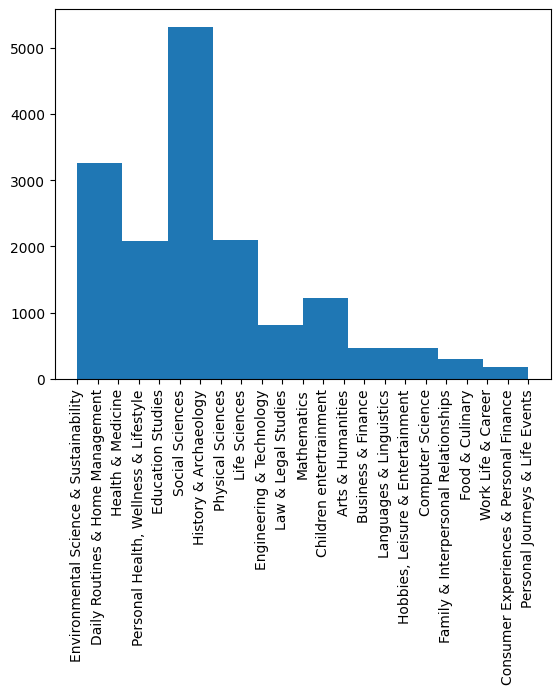

In [21]:
import matplotlib.pyplot as plt
plt.hist(x['label_category'])
plt.xticks(rotation=90)

([0, 1, 2, 3],
 [Text(0, 0, 'university degree'),
  Text(1, 0, 'middle school'),
  Text(2, 0, 'high school'),
  Text(3, 0, 'primary school')])

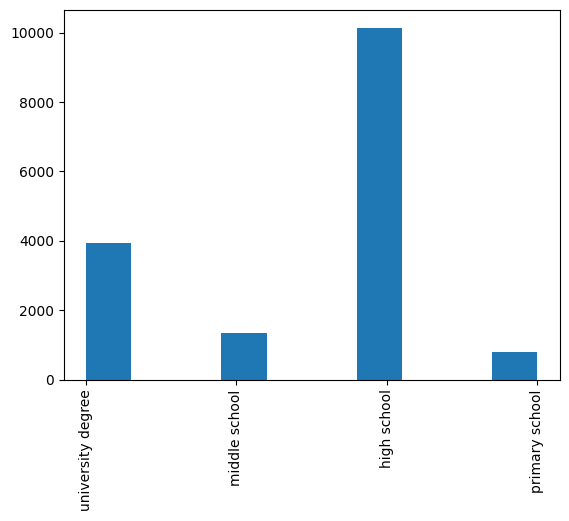

In [22]:
plt.hist(x['label_degree'])
plt.xticks(rotation=90)

In [ ]:
# Generating synthetic data

In [27]:
import json

def generate_synthetic_data(sample_text):
    """
    Uses Gemini to generate synthetic data from a sample text. The synthetic data is obtained by summarizing,
    paraphrasing, extracting keywords, and creating a creative variant of the text.

    Args:
        sample_text (str): The sample text on which to base the synthetic data generation.

    Returns:
        dict: A dictionary containing synthesized data with the following keys:
              - "summary": A succinct summary of the text.
              - "paraphrase": A reworded version of the text.
              - "keywords": A list of keywords extracted from the text.
              - "synthetic_variant": A creatively modified variant of the text.
              Returns error messages in the dictionary fields if an error occurs.
    """
    # Ensure text is not empty or just whitespace
    if not sample_text or sample_text.isspace():
        print("Warning: Skipping empty or whitespace-only text.")
        return {
            "summary": None,
            "paraphrase": None,
            "keywords": None,
            "synthetic_variant": None,
        }

    # Limit text length to avoid exceeding model limits (adjust as needed)
    max_length = 15000  # Example limit, adjust based on model token limits if needed
    if len(sample_text) > max_length:
        sample_text = sample_text[:max_length] + "..."  # Truncate

    prompt = f"""
You are an advanced language model designed to perform text augmentation. Given the following text, your task is to generate synthetic data by performing these four tasks:

1. **Summarization**: Provide a succinct summary of the text.
2. **Paraphrasing**: Rephrase the text while preserving its meaning.
3. **Synthetic Variant**: Generate one additional variant of the text with creative modifications (e.g. varying sentence structure or introducing subtle stylistic changes).

Please provide your answer ONLY in the following JSON format:
{{
    "summary": "Summarized version of the text.",
    "paraphrase": "Paraphrased version of the text.",
    "synthetic_variant": "Creative synthetic variant of the text."
}}

Example Response:
{{
    "summary": "A brief summary of the sample text.",
    "paraphrase": "A reworded version of the sample text.",
    "synthetic_variant": "An alternative version of the text with creative modifications."
}}

Text:
\"{sample_text}\"

Output ONLY the JSON object.
"""

    try:
        model = genai.GenerativeModel("gemini-1.5-flash")  # Replace with your actual model name
        response = model.generate_content(
            prompt,
            generation_config=genai.types.GenerationConfig(
                temperature=0.2,  # Adjust temperature to balance creativity and fidelity
                # You can also fine-tune the max output tokens if necessary, e.g.
                # max_output_tokens=150,
            )
        )

        raw_response_text = response.text.strip()
        # Remove markdown formatting if present
        if raw_response_text.startswith("```json"):
            raw_response_text = raw_response_text[7:]
        if raw_response_text.endswith("```"):
            raw_response_text = raw_response_text[:-3]
        raw_response_text = raw_response_text.strip()

        # Parse the JSON response
        result = json.loads(raw_response_text)
        # Optionally, validate that required keys are present
        for key in ["summary", "paraphrase", "synthetic_variant"]:
            if key not in result:
                print(f"Warning: Expected key '{key}' not found in the output. Setting its value to None.")
                result[key] = None

        return result

    except json.JSONDecodeError:
        print(f"Error: Failed to decode JSON response: {raw_response_text}")
        return {
            "summary": "Error: JSON Decode",
            "paraphrase": "Error: JSON Decode",
            "synthetic_variant": "Error: JSON Decode",
        }
    except ValueError as ve:
        print(f"Error: Gemini API returned ValueError. Raw response: {response.text if 'response' in locals() else 'N/A'}. Details: {ve}")
        return {
            "summary": "Error: API Value",
            "paraphrase": "Error: API Value",
            "synthetic_variant": "Error: API Value",
        }
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return {
            "summary": "Error: API Call",
            "paraphrase": "Error: API Call",
            "synthetic_variant": "Error: API Call",
        }

In [28]:
generate_synthetic_data(df['text'][0])

{'summary': 'Card Sharks, a game show airing since 1978, features contestants guessing higher or lower than revealed cards to win money.  Different versions have existed, with varying rules and hosts, but the core gameplay of card prediction remains.',
 'paraphrase': 'Since its debut in 1978, the game show Card Sharks has undergone several iterations.  The core concept involves two players competing to predict whether subsequent cards will be higher or lower in value, accumulating winnings through successful predictions.  Various hosts and rule modifications have marked its long run on television, with some versions proving more popular than others.',
 'synthetic_variant': "From its 1978 premiere under Jim Perry's charismatic hosting, Card Sharks has captivated audiences with its simple yet thrilling premise: outguess your opponent by predicting the ascending or descending order of playing cards.  The show's enduring appeal, despite numerous revivals and rule tweaks, lies in its blend 

# Part 2

# Loading the tokenizer

In [23]:
from transformers import PreTrainedTokenizerFast
import numpy as np
enc = PreTrainedTokenizerFast.from_pretrained('./dev/data/simple_english.parquet/custom_tokenizer')

In [24]:
enc.encode('Hello')

[10754, 83]

In [25]:
with open('./dev/data/simple_english.parquet/simple_english.parquet_custom_train_000041.bin', "rb") as f:
    # first read the header, which is 256 int32 integers (4 bytes each)
    header = np.frombuffer(f.read(256*4), dtype=np.int32)
    ntok = header[2] # number of tokens (claimed)
    # the rest of it are tokens, stored as uint16
    tokens = np.frombuffer(f.read(), dtype=np.uint32)

In [26]:
decoded_text = enc.decode(tokens[100:200]).replace(" ", "").replace("Ġ", " ").replace(" ##", "").replace('Ċ','\n')

In [27]:
print(decoded_text)

 counties carrying horns and drums and other noisemakers met and formed a circle many miles in diameter, driving all the wild game, including wolves, before them. âĢľThere were but few wolves killed,âĢĿ reported one account, because as the circle closed, the wolves hid in the long grass until they could break through the lines and escape.
The ecosystem that sustained such abundant life was typical of the central third of Illinois. Surveys by the Government Land Office from around 1820 suggest that tallgrass prairie


In [11]:
import polars as pl
pl.read_parquet('simple_english.parquet')['number_of_words'].sum()

32077573